In [ ]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")

In [4]:
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import accuracy_score
from keras import backend
import glob
import random
import CNN_Module as cnn_module
import models
import glue_code

ModuleNotFoundError: No module named 'DataGenerator'

In [46]:
model_noBN_no_aug = models.get_luke_model_noBN(80)
model_noBN = models.get_luke_model_noBN(80)
model_no_aug = models.get_luke_model(80)
model_BN = models.get_luke_model(80)

In [ ]:
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train_no_aug, params_test = cnn_module.get_params_train_test(80,augment_valid,augment_valid)
params_train_aug, params_test = cnn_module.get_params_train_test(80,augment_train,augment_valid)
params_test['batch_size']=24
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
#prep cells for feeding into CNN
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/control/'))
sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)

train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)

train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus

random.shuffle(train_labels)
random.shuffle(test_labels)

video_path = '/cropped_video80'
sample_gap = 10
im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
random.shuffle(im_paths_train)
random.shuffle(im_paths_test)

In [ ]:
training_generator_no_aug = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train_no_aug)
training_generator_aug = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train_aug)
prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)       

In [63]:
sample_gap=10
epochs=30
stepsperepoch=100
video_path = '/cropped_video80'
validate_steps = len(im_paths_test)//24.

noBN_no_aug_result=[]
noBN_result = [] 
no_aug_result=[]
result = []
for repeat in np.arange(0,5):
    print(repeat)
    model_noBN_no_aug = models.get_luke_model_noBN(80)
    model_noBN = models.get_luke_model_noBN(80)
    model_no_aug = models.get_luke_model(80)
    model_BN = models.get_luke_model(80)
    
    model_noBN_no_aug.fit_generator(generator=training_generator_no_aug,epochs = epochs,steps_per_epoch=stepsperepoch,validation_data=prediction_generator,validation_steps=validate_steps,verbose=0)
    noBN_no_aug_result.append(model_noBN_no_aug.history.history['val_acc'])
    print('done1',)
    model_noBN.fit_generator(generator=training_generator_aug,epochs = epochs,steps_per_epoch=stepsperepoch,validation_data=prediction_generator,validation_steps=validate_steps,verbose=0)
    noBN_result.append(model_noBN.history.history['val_acc'])
    print('done2',)
    model_no_aug.fit_generator(generator=training_generator_no_aug,epochs = epochs,steps_per_epoch=stepsperepoch,validation_data=prediction_generator,validation_steps=validate_steps,verbose=0)
    no_aug_result.append(model_no_aug.history.history['val_acc'])
    print('done3',)
    model_BN.fit_generator(generator=training_generator_aug,epochs = epochs,steps_per_epoch=stepsperepoch,validation_data=prediction_generator,validation_steps=validate_steps,verbose=0)
    result.append(model_BN.history.history['val_acc'])
    print('done4')

0
done1
done2
done3
done4
1
done1
done2
done3
done4
2
done1
done2
done3
done4
3
done1
done2
done3
done4
4
done1
done2
done3
done4


In [64]:
result = np.array(result)
no_aug_result = np.array(no_aug_result)
noBN_result = np.array(noBN_result)
noBN_no_aug_result = np.array(noBN_no_aug_result)

In [100]:
xs_scatter =[]
for i in range(5):
    i = np.arange(1,31)
    i = list(i)
    xs_scatter.extend(i)

In [177]:
os.mkdir('/home/ubuntu/data/figures')

In [176]:
import pickle
pickle.dump(result,open('/home/ubuntu/data/code/2dCNN/Aug_BN_results/aug_bn.p','wb'))
pickle.dump(no_aug_result,open('/home/ubuntu/data/code/2dCNN/Aug_BN_results/no_aug_bn.p','wb'))
pickle.dump(noBN_result,open('/home/ubuntu/data/code/2dCNN/Aug_BN_results/aug_no_bn.p','wb'))
pickle.dump(noBN_no_aug_result,open('/home/ubuntu/data/code/2dCNN/Aug_BN_results/no_aug_no_bn.p','wb'))

In [2]:
import pickle
result = pickle.load(open('/home/ubuntu/data/code/2dCNN/Aug_BN_results/aug_bn.p','rb'))
no_aug_result =pickle.load(open('/home/ubuntu/data/code/2dCNN/Aug_BN_results/no_aug_bn.p','rb'))
noBN_result = pickle.load(open('/home/ubuntu/data/code/2dCNN/Aug_BN_results/aug_no_bn.p','rb'))
noBN_no_aug_result = pickle.load(open('/home/ubuntu/data/code/2dCNN/Aug_BN_results/no_aug_no_bn.p','rb'))

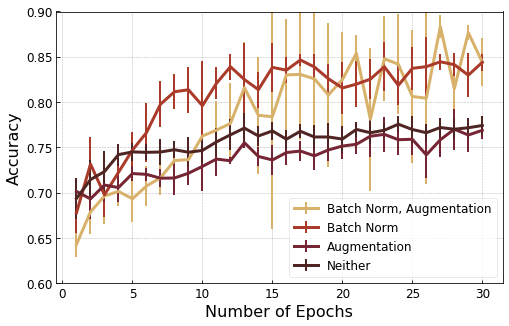

In [7]:
plt.style.use('bmh')
plt.rcParams.update({"figure.figsize" : (8, 5),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
elinewidth=2
xs = np.arange(1,31)
linewidth=3
markersize=3
capsize=0
plt.errorbar(xs,np.average(result,axis=0),yerr=np.std(result,axis=0),label='Batch Norm, Augmentation',elinewidth=elinewidth,capsize=capsize,linewidth=linewidth,color='#D8B26A')
#plt.plot(xs_scatter,result.flatten(),color='#D8B26A',linewidth=0,marker='o',markersize=markersize)

plt.errorbar(xs,np.average(no_aug_result,axis=0),yerr=np.std(no_aug_result,axis=0),label = 'Batch Norm',elinewidth=elinewidth,capsize=capsize,linewidth=linewidth,color='#AA3A29')
#plt.plot(xs_scatter,no_aug_result.flatten(),color='#AA3A29',linewidth=0,marker='o',markersize=markersize)

plt.errorbar(xs,np.average(noBN_result,axis=0),yerr=np.std(noBN_result,axis=0),label = 'Augmentation',elinewidth=elinewidth,capsize=capsize,linewidth=linewidth,color='#752534')
#plt.plot(xs_scatter,noBN_result.flatten(),color='#752534',linewidth=0,marker='o',markersize=markersize)

plt.errorbar(xs,np.average(noBN_no_aug_result,axis=0),yerr=np.std(noBN_no_aug_result,axis=0),label = 'Neither',elinewidth=elinewidth,capsize=capsize,linewidth=linewidth,color='#4F2524')
#plt.errorbar(xs,np.std(noBN_no_aug_result,axis=0),color='#4F2524',linewidth=1,)


plt.ylim(0.60,0.90)
plt.xlabel('Number of Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend(loc=4,frameon=True,fontsize=12)
plt.savefig('/home/ubuntu/data/figures/Batch_Aug.png',dpi=300)

In [146]:
np.std(noBN_no_aug_result,axis=0)

array([0.02276244, 0.02113471, 0.02243523, 0.01202234, 0.00963955,
       0.00872179, 0.0148492 , 0.00943706, 0.01652153, 0.0138185 ,
       0.01515133, 0.01714368, 0.01666344, 0.01128276, 0.0095231 ,
       0.01060134, 0.00773026, 0.01304159, 0.01542813, 0.01496122,
       0.00800796, 0.01246417, 0.00836053, 0.00914808, 0.01463888,
       0.00931643, 0.01041978, 0.01098559, 0.01127662, 0.01062599])

In [172]:
noBN_no_aug_result.flatten()

array([0.72368421, 0.70087719, 0.73947368, 0.72280702, 0.74298246,
       0.75482456, 0.77017544, 0.7627193 , 0.73991228, 0.76447368,
       0.78245614, 0.79342105, 0.7877193 , 0.76535088, 0.78157895,
       0.74605263, 0.77456141, 0.77763158, 0.77105263, 0.74166667,
       0.77192982, 0.75701755, 0.78026316, 0.77149123, 0.77236842,
       0.77807018, 0.77982456, 0.77017544, 0.78947369, 0.78640351,
       0.70219298, 0.69078947, 0.68552632, 0.74912281, 0.73552632,
       0.73333333, 0.73070175, 0.74166667, 0.74824561, 0.7377193 ,
       0.75175439, 0.75307018, 0.76491228, 0.74868421, 0.76096491,
       0.75570175, 0.7622807 , 0.75394737, 0.73245614, 0.74517544,
       0.75964913, 0.75350877, 0.75833333, 0.76973684, 0.76710527,
       0.75833334, 0.76842106, 0.75438596, 0.7754386 , 0.7627193 ,
       0.69868421, 0.74429825, 0.75087719, 0.75      , 0.73684211,
       0.75131579, 0.73070175, 0.74298245, 0.75789473, 0.7618421 ,
       0.73991228, 0.75438596, 0.74429824, 0.75043859, 0.75438

In [98]:
xs_scatter =[]
for i in range(5):
    i = np.arange(1,31)
    i = list(i)
    xs_scatter.extend(i)

In [99]:
xs_scatter

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]